In [26]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

In [27]:
class Model(nn.Module):
    # defines a fully connected neural network, with a tanh activation function
    def __init__(self, inputs, outputs, hidden, n_layers):
        super().__init__()
        act_f = nn.Tanh

        # First layer, "*" unpacks the list into arguments of nn.Sequential
        self.fcs = nn.Sequential(*[
                        nn.Linear(inputs, hidden),
                        act_f()])
        
        # Hidden layers with activation function
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(hidden, hidden),
                            act_f()]) for _ in range(n_layers-1)])
        
        # Final layer that maps from last hidden layer to output size
        self.fce = nn.Linear(hidden, outputs)
    
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [28]:
def infer_with_model(model: Model, weights, y):
    model.load_state_dict(weights)

    return model(y)

/tmp/ipykernel_6709/3951200703.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load("test.pt", map_location=torch.device("cpu"))


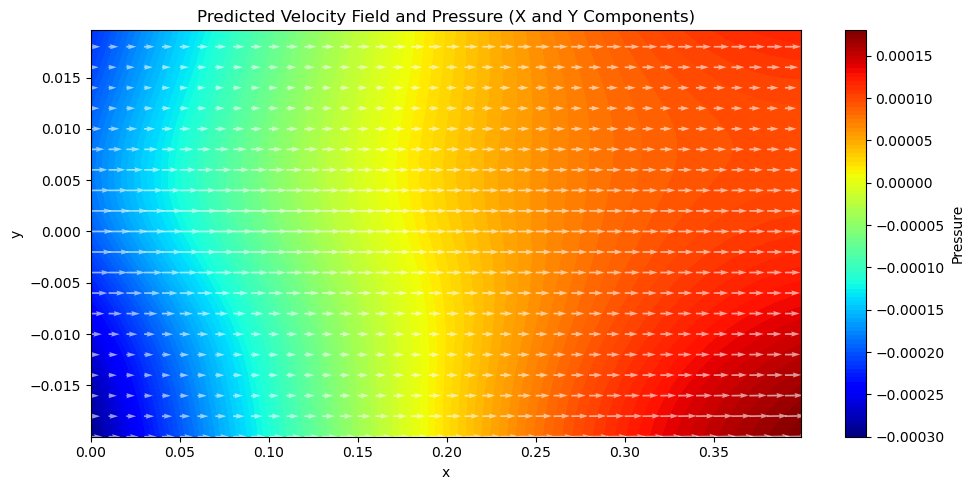

In [37]:
weights = torch.load("test.pt", map_location=torch.device("cpu"))
poiseuille_model = Model(2, 3, 100, 10).to("cpu")

to_infer = []

for i in range(-50, 50, 1):
    for j in range(0, 400, 1):
        to_infer.append([j/1000, i/2500])

to_infer = np.array(to_infer, dtype="float32")

yhp = infer_with_model(poiseuille_model, weights, torch.from_numpy(to_infer))

u_pred = yhp[:, 0].detach().cpu().numpy()
v_pred = yhp[:, 1].detach().cpu().numpy()
p_pred = yhp[:, 2].detach().cpu().numpy()
x = to_infer[:, 0]
y = to_infer[:, 1]

# Create dataframe
df = pd.DataFrame({'x': x, 'y': y, 'u': u_pred, 'v': v_pred, 'p':p_pred})
df['speed'] = p_pred

# Pivot for grid-based plotting
pivot_x = df.pivot_table(index='y', columns='x', values='u')
pivot_y = df.pivot_table(index='y', columns='x', values='v')
pivot_speed = df.pivot_table(index='y', columns='x', values='speed')

# Get meshgrid
X, Y = np.meshgrid(pivot_x.columns.values, pivot_x.index.values)

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
c = ax.contourf(X, Y, pivot_speed.values, levels=100, cmap='jet')
cb = fig.colorbar(c, ax=ax, label='Pressure')

# Optional quiver (velocity vectors, skip some for clarity)
skip = (slice(None, None, 5), slice(None, None, 10))
ax.quiver(X[skip], Y[skip], pivot_x.values[skip], pivot_y.values[skip], color='white', alpha=0.6)

# Styling
ax.set_title('Predicted Velocity Field and Pressure (X and Y Components)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('auto')
plt.tight_layout()
plt.show()

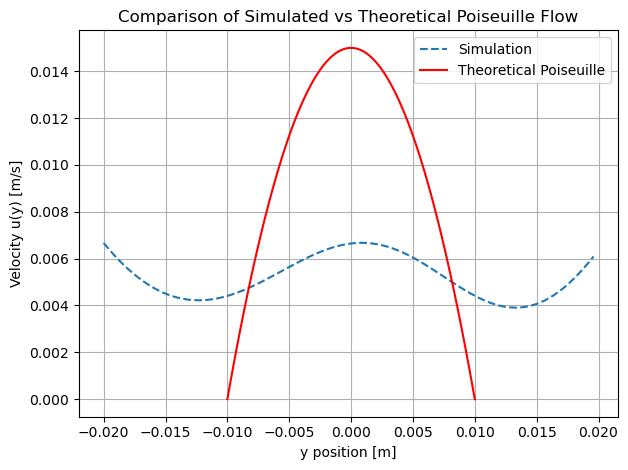

In [69]:
plt.plot(
    df[df['x'] == 0.2]["y"],
    df[df['x'] == 0.2]['u'].values,
    label='Simulation',
    linestyle='--'
)

real = []
indices = []
h = 0.01          # half channel height
ubar = 0.01       # average velocity
N = 100           # number of points

for i in range(N):
    y = -h + (2 * h) * i / (N - 1)  # evenly spaced from -h to +h
    indices.append(y)
    u = (3/2) * ubar * (1 - (y**2) / (h**2))
    real.append(u)

plt.plot(indices, real, label='Theoretical Poiseuille', color='red')

plt.xlabel('y position [m]')
plt.ylabel('Velocity u(y) [m/s]')
plt.title('Comparison of Simulated vs Theoretical Poiseuille Flow')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
